# Telco Customer Churn - Data Preprocessing

This notebook prepares the dataset for machine learning model training.

**Preprocessing Steps:**
1. Load and inspect data
2. Handle missing values
3. Feature engineering
4. Encode categorical variables (Label Encoding for SMOTE-NC)
5. Scale numerical features
6. Handle class imbalance (SMOTE-NC)
7. One-hot expand categorical features
8. Train-test split and save processed data

## 1. Setup & Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTENC
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
print('Libraries loaded successfully')

In [2]:
df = pd.read_csv('../data/teleco-customer-churn.csv')
print(f'Original dataset shape: {df.shape}')
df.head()

Original dataset shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 2. Handle Missing Values

In [3]:
# Check missing values
print('Missing values per column:')
print(df.isnull().sum())
print(f'\nTotal missing: {df.isnull().sum().sum()}')

Missing values per column:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Total missing: 0


In [4]:
# TotalCharges has empty strings - convert to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Check missing after conversion
missing_total = df['TotalCharges'].isnull().sum()
print(f'Missing TotalCharges: {missing_total}')

# These are likely new customers with tenure=0
print('\nRows with missing TotalCharges:')
print(df[df['TotalCharges'].isnull()][['customerID', 'tenure', 'MonthlyCharges', 'TotalCharges']])

Missing TotalCharges: 11

Rows with missing TotalCharges:
      customerID  tenure  MonthlyCharges  TotalCharges
488   4472-LVYGI       0           52.55           NaN
753   3115-CZMZD       0           20.25           NaN
936   5709-LVOEQ       0           80.85           NaN
1082  4367-NUYAO       0           25.75           NaN
1340  1371-DWPAZ       0           56.05           NaN
3331  7644-OMVMY       0           19.85           NaN
3826  3213-VVOLG       0           25.35           NaN
4380  2520-SGTTA       0           20.00           NaN
5218  2923-ARZLG       0           19.70           NaN
6670  4075-WKNIU       0           73.35           NaN
6754  2775-SEFEE       0           61.90           NaN


In [5]:
# Fill missing TotalCharges with 0 (new customers) or MonthlyCharges
# For new customers (tenure=0), TotalCharges should logically be 0 or their first month's charge
df['TotalCharges'] = df.apply(
    lambda x: x['MonthlyCharges'] if pd.isnull(x['TotalCharges']) else x['TotalCharges'], 
    axis=1
)

print(f'Missing values after imputation: {df.isnull().sum().sum()}')

Missing values after imputation: 0


## 3. Feature Engineering

In [6]:
# Drop customerID - not useful for prediction
# Also drop SeniorCitizen_label (redundant with numeric SeniorCitizen)
df = df.drop(['customerID', 'SeniorCitizen_label'], axis=1, errors='ignore')

# Create derived features
# Average monthly spend
df['AvgMonthlySpend'] = df['TotalCharges'] / (df['tenure'] + 1)  # +1 to avoid division by zero

# FIX: TenureGroup bins — use -1 as lower bound to include tenure=0
# Original bins=[0, 12, 24, 48, 72] excluded tenure=0 (pd.cut uses exclusive lower bound)
df['TenureGroup'] = pd.cut(df['tenure'], 
                           bins=[-1, 12, 24, 48, 72], 
                           labels=['0-1yr', '1-2yr', '2-4yr', '4-6yr'])

# Count of additional services
service_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                'TechSupport', 'StreamingTV', 'StreamingMovies']
df['TotalServices'] = df[service_cols].apply(
    lambda x: (x == 'Yes').sum(), axis=1
)

print('New features created:')
print(f'TenureGroup NaN count: {df["TenureGroup"].isna().sum()} (should be 0)')
print(df[['tenure', 'TenureGroup', 'MonthlyCharges', 'TotalCharges', 'AvgMonthlySpend', 'TotalServices']].head())

## 4. Encode Categorical Variables

In [7]:
# Identify column types
print('Column data types:')
print(df.dtypes.value_counts())

# Get categorical columns
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print(f'\nCategorical columns ({len(cat_cols)}): {cat_cols}')

Column data types:
object      16
int64        3
float64      3
category     1
Name: count, dtype: int64

Categorical columns (17): ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn', 'TenureGroup']


In [8]:
# Check unique values in categorical columns
for col in cat_cols:
    print(f'{col}: {df[col].unique()}')

gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn: ['No' 'Yes']
TenureGroup: ['0-1yr', '2-4yr', '1-2yr', '4-6yr', NaN]
Categories (4, object): ['0-1yr' < '1-2yr' < '2-4yr' < '4-6yr']


In [9]:
# Binary encoding for Yes/No columns
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0})

# Gender encoding
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})

print('Binary columns encoded')

Binary columns encoded


In [10]:
# Label-encode multi-category columns (NOT one-hot)
# SMOTE-NC requires each categorical feature as a single label-encoded column.
# We will one-hot encode AFTER SMOTE-NC to preserve categorical integrity.
multi_cat_cols = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                  'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                  'Contract', 'PaymentMethod', 'TenureGroup']

label_encoders = {}
for col in multi_cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le
    print(f'  {col}: {len(le.classes_)} classes -> {list(le.classes_)}')

print(f'\nShape after label encoding: {df.shape}')

In [11]:
# Column name cleaning will be done after SMOTE-NC + one-hot expansion
# For now, work with the label-encoded DataFrame 'df' directly
df_encoded = df  # alias for consistency with downstream cells
print('Label-encoded DataFrame ready')
df_encoded.head()

## 5. Scale Numerical Features

In [12]:
# Identify numerical columns to scale
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'AvgMonthlySpend', 'TotalServices']

# Check distributions before scaling
print('Numerical features statistics before scaling:')
df_encoded[numerical_cols].describe().round(2)

Numerical features statistics before scaling:


,tenure,MonthlyCharges,TotalCharges,AvgMonthlySpend,TotalServices
count,7043.00,7043.00,7043.00,7043.00,7043.00
mean,32.37,64.76,2279.80,59.06,2.04
std,24.56,30.09,2266.73,30.51,1.85
min,0.00,18.25,18.80,9.18,0.00
25%,9.00,35.50,398.55,26.18,0.00
50%,29.00,70.35,1394.55,61.02,2.00
75%,55.00,89.85,3786.60,84.83,3.00
max,72.00,118.75,8684.80,118.97,6.00


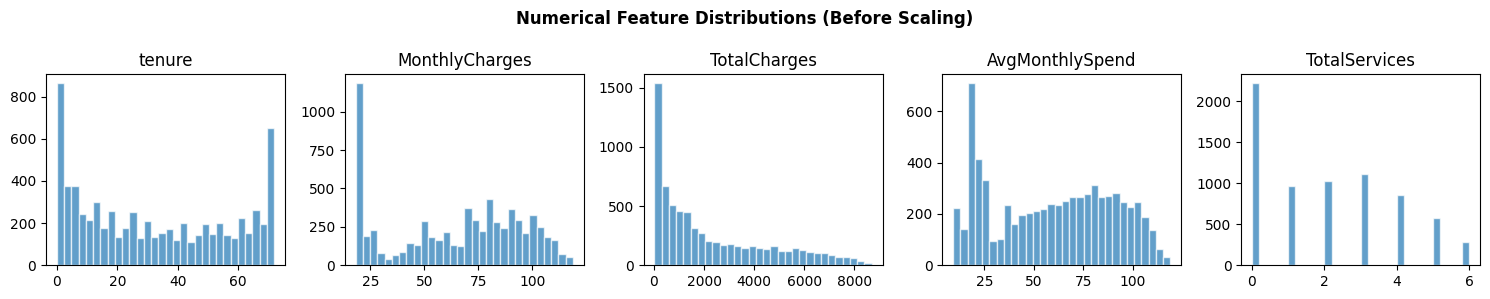

In [13]:
# Visualize distributions
fig, axes = plt.subplots(1, len(numerical_cols), figsize=(15, 3))
for i, col in enumerate(numerical_cols):
    axes[i].hist(df_encoded[col], bins=30, edgecolor='white', alpha=0.7)
    axes[i].set_title(col)
plt.suptitle('Numerical Feature Distributions (Before Scaling)', fontweight='bold')
plt.tight_layout()
plt.show()

In [14]:
# Apply StandardScaler
scaler = StandardScaler()
df_encoded[numerical_cols] = scaler.fit_transform(df_encoded[numerical_cols])

print('Numerical features after scaling:')
df_encoded[numerical_cols].describe().round(2)

Numerical features after scaling:


,tenure,MonthlyCharges,TotalCharges,AvgMonthlySpend,TotalServices
count,7043.00,7043.00,7043.00,7043.00,7043.00
mean,-0.00,-0.00,-0.00,0.00,0.00
std,1.00,1.00,1.00,1.00,1.00
min,-1.32,-1.55,-1.00,-1.63,-1.10
25%,-0.95,-0.97,-0.83,-1.08,-1.10
50%,-0.14,0.19,-0.39,0.06,-0.02
75%,0.92,0.83,0.66,0.84,0.52
max,1.61,1.79,2.83,1.96,2.14


## 6. Handle Class Imbalance (SMOTE-NC)

In [19]:
# One-hot encode AFTER SMOTE-NC
# This ensures each categorical group sums to exactly 1 in every row.

def expand_one_hot(data, col, le):
    """Convert a label-encoded column back to one-hot columns."""
    int_vals = data[col].round().astype(int).clip(0, len(le.classes_) - 1)
    categories = le.classes_
    for cat in categories:
        cat_idx = list(categories).index(cat)
        clean_name = f'{col}_{cat}'.replace(' ', '_').replace('(', '').replace(')', '').replace('-', '_')
        data[clean_name] = (int_vals == cat_idx).astype(int)
    data = data.drop(columns=[col])
    return data

def expand_all_one_hot(data, multi_cat_cols, label_encoders):
    for col in multi_cat_cols:
        data = expand_one_hot(data, col, label_encoders[col])
    return data

def clean_columns(df):
    df.columns = df.columns.str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
    df.columns = df.columns.str.replace('-', '_')
    return df

# Expand SMOTE training data
X_train_oh = clean_columns(expand_all_one_hot(
    pd.DataFrame(X_train_resampled, columns=X_train.columns),
    multi_cat_cols, label_encoders
))

# Expand original training data
X_train_orig_oh = clean_columns(expand_all_one_hot(
    pd.DataFrame(X_train.values, columns=X_train.columns),
    multi_cat_cols, label_encoders
))

# Expand test data
X_test_oh = clean_columns(expand_all_one_hot(
    pd.DataFrame(X_test.values, columns=X_test.columns),
    multi_cat_cols, label_encoders
))

print(f'After one-hot expansion:')
print(f'  SMOTE train: {X_train_oh.shape}')
print(f'  Original train: {X_train_orig_oh.shape}')
print(f'  Test: {X_test_oh.shape}')

Target variable distribution:
Churn
0    5174
1    1869
Name: count, dtype: int64

Churn rate: 26.54%


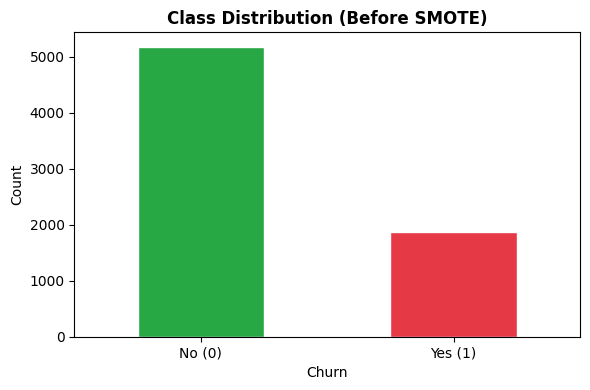

In [15]:
# Check class distribution
print('Target variable distribution:')
print(df_encoded['Churn'].value_counts())
print(f'\nChurn rate: {df_encoded["Churn"].mean()*100:.2f}%')

# Visualize imbalance
plt.figure(figsize=(6, 4))
df_encoded['Churn'].value_counts().plot(kind='bar', color=['#28A745', '#E63946'], edgecolor='white')
plt.title('Class Distribution (Before SMOTE)', fontweight='bold')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.xticks([0, 1], ['No (0)', 'Yes (1)'], rotation=0)
plt.tight_layout()
plt.show()

In [16]:
# Separate features and target
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

print(f'Features shape: {X.shape}')
print(f'Target shape: {y.shape}')

Features shape: (7043, 46)
Target shape: (7043,)


In [17]:
# Split data BEFORE applying SMOTE (important to avoid data leakage)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f'Training set: {X_train.shape[0]} samples')
print(f'Test set: {X_test.shape[0]} samples')
print(f'\nTraining set class distribution:')
print(y_train.value_counts())

Training set: 5634 samples
Test set: 1409 samples

Training set class distribution:
Churn
0    4139
1    1495
Name: count, dtype: int64


In [18]:
# FIX: Apply SMOTE-NC instead of standard SMOTE
# SMOTE-NC correctly handles categorical features by treating them atomically
# rather than interpolating between one-hot columns (which corrupts categories).

# Identify categorical feature indices (the label-encoded columns)
categorical_indices = [list(X_train.columns).index(col) for col in multi_cat_cols]

print(f'Applying SMOTE-NC with {len(categorical_indices)} categorical features...')
print(f'Categorical columns: {multi_cat_cols}')

smote_nc = SMOTENC(categorical_features=categorical_indices, random_state=42)
X_train_resampled, y_train_resampled = smote_nc.fit_resample(X_train, y_train)

print(f'\nAfter SMOTE-NC:')
print(f'Training set: {X_train_resampled.shape[0]} samples')
print(f'\nResampled class distribution:')
print(pd.Series(y_train_resampled).value_counts())

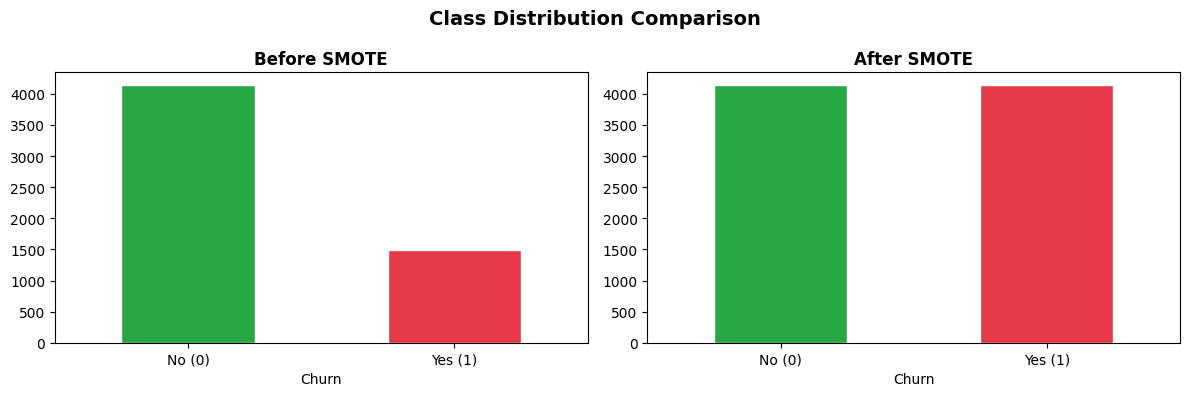

In [19]:
# Visualize before/after SMOTE
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Before
y_train.value_counts().plot(kind='bar', ax=axes[0], color=['#28A745', '#E63946'], edgecolor='white')
axes[0].set_title('Before SMOTE', fontweight='bold')
axes[0].set_xticklabels(['No (0)', 'Yes (1)'], rotation=0)

# After
pd.Series(y_train_resampled).value_counts().plot(kind='bar', ax=axes[1], color=['#28A745', '#E63946'], edgecolor='white')
axes[1].set_title('After SMOTE', fontweight='bold')
axes[1].set_xticklabels(['No (0)', 'Yes (1)'], rotation=0)

plt.suptitle('Class Distribution Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 7. Save Processed Data

In [21]:
# Save processed datasets
import os

# Create processed data directory
os.makedirs('../data/processed', exist_ok=True)

# Save training data (with SMOTE-NC, one-hot expanded)
train_df = X_train_oh.copy()
train_df['Churn'] = y_train_resampled.values if hasattr(y_train_resampled, 'values') else y_train_resampled
train_df.to_csv('../data/processed/train_smote.csv', index=False)

# Save original training data (without SMOTE, one-hot expanded)
train_orig_df = X_train_orig_oh.copy()
train_orig_df['Churn'] = y_train.values
train_orig_df.to_csv('../data/processed/train_original.csv', index=False)

# Save test data (one-hot expanded)
test_df = X_test_oh.copy()
test_df['Churn'] = y_test.values
test_df.to_csv('../data/processed/test.csv', index=False)

print('Saved files:')
print(f'  - train_smote.csv: {train_df.shape}')
print(f'  - train_original.csv: {train_orig_df.shape}')
print(f'  - test.csv: {test_df.shape}')

In [22]:
# Save feature names and scaler for later use
import pickle

# Save feature names (from one-hot expanded columns)
feature_names = X_train_oh.columns.tolist()
with open('../data/processed/feature_names.pkl', 'wb') as f:
    pickle.dump(feature_names, f)

# Save scaler
with open('../data/processed/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print(f'Feature names saved ({len(feature_names)} features)')
print('Scaler saved')

## Summary

In [23]:
print('=' * 60)
print('           PREPROCESSING SUMMARY')
print('=' * 60)
print(f'\nOriginal dataset: {7043} rows')
print(f'Features created: {len(X_train_oh.columns)}')
print(f'\nMissing values handled: TotalCharges imputed')
print(f'\nFeature Engineering:')
print(f'  - AvgMonthlySpend: TotalCharges / (tenure + 1)')
print(f'  - TenureGroup: Binned tenure into 4 groups (bins=[-1,12,24,48,72])')
print(f'  - TotalServices: Count of subscribed services')
print(f'\nEncoding:')
print(f'  - Binary: gender, Partner, Dependents, PhoneService, PaperlessBilling')
print(f'  - Label → SMOTE-NC → One-Hot: InternetService, Contract, PaymentMethod, etc.')
print(f'\nScaling: StandardScaler on numerical features')
print(f'\nClass Imbalance (SMOTE-NC):')
print(f'  - Original: {y_train.value_counts()[0]} No, {y_train.value_counts()[1]} Yes')
print(f'  - After SMOTE-NC: {pd.Series(y_train_resampled).value_counts()[0]} No, {pd.Series(y_train_resampled).value_counts()[1]} Yes')
print(f'\nData Split:')
print(f'  - Training (with SMOTE-NC): {train_df.shape[0]} samples')
print(f'  - Test: {test_df.shape[0]} samples')
print('=' * 60)